In [1]:
%%bash

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /private/var/folders/yx/1rhfv1rs5psg_gv9g330q9900000gn/T/pip-req-build-xftgbg78


  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /private/var/folders/yx/1rhfv1rs5psg_gv9g330q9900000gn/T/pip-req-build-xftgbg78


  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


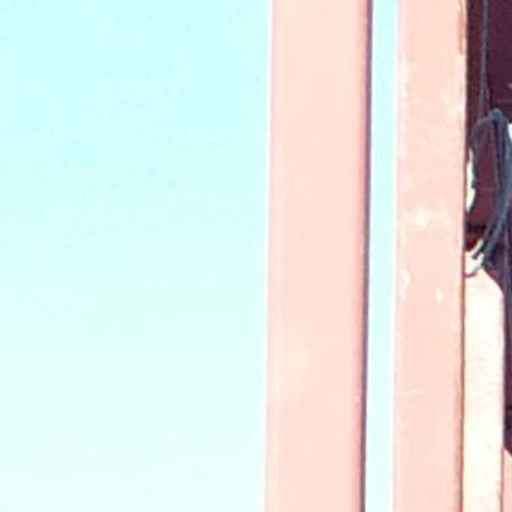

In [5]:
from PIL import Image
Image.open('smallsets/train/images/5_0.png')

In [6]:
mask = Image.open('smallsets/train/masks/5_0.png')

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class SteelDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        img = Image.open(img_path)
        # Converting mask images to grey scale
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)

        # instances are encoded as different colors
        #obj_ids = np.unique(mask) #[0 1 2]
        # first id is the background, so remove it
        #obj_ids = obj_ids[1:] #[1 2]
        
        #Only having 1 type object
        obj_ids = np.array([1])

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        #print(obj_ids[:, None, None]) #[[[1]]

                                      #[[2]]] 2x1x1

        #print(masks.shape) #2x536x559

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
dataset = SteelDataset('new_data/train')
#for idx in range(200, 500):
    #print('idx is ', idx)
dataset[360]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 {'boxes': tensor([[  0.,   0., 511., 511.]]),
  'labels': tensor([1]),
  'masks': tensor([[[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8),
  'image_id': tensor([360]),
  'area': tensor([261121.]),
  'iscrowd': tensor([0])})

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_steel_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [3]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [3]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = SteelDataset('new_data/train', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

/Users/zhouqianjiang/miniforge3/envs/pytorchtest/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/zhouqianjiang/miniforge3/envs/pytorchtest/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# use our dataset and defined transformations
dataset = SteelDataset('new_data/train', get_transform(train=False))
dataset_test = SteelDataset('new_data/test', get_transform(train=False))

# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_steel_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=6,
                                               gamma=0.1)

/Users/zhouqianjiang/miniforge3/envs/pytorchtest/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def IoU(y_true, y_pred):
  # Intersection over Union loss function
  intersection = y_true*y_pred
  union = (y_true+y_pred)-(y_true*y_pred)
  return np.sum(intersection)/np.sum(union)

def confusion_matrix(y_true, y_pred):
    y_true= y_true.flatten()
    y_pred = y_pred.flatten()*2
    cm = y_true+y_pred
    cm = np.bincount(cm, minlength=4)
    tn, fn, fp, tp = cm
    return tn, fn, fp, tp

def get_precision(y_true, y_pred):
    """Return precision"""
    tn, fn, fp, tp = confusion_matrix(y_true, y_pred)
    precision = tp / (tp + fp)
    return precision

def get_recall(y_true, y_pred):
    """Return recall"""
    tn, fn, fp, tp = confusion_matrix(y_true, y_pred)
    recall = tp / (tp + fn)
    return recall

def get_f1_score(y_true, y_pred):
    """Return f1 score covering edge cases"""
    tn, fn, fp, tp = confusion_matrix(y_true, y_pred)
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)
    return f1_score

In [ ]:
# let's train it for 20 epochs
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

    print('Starting to calculate IoU and Precision, Recall, F1 score')
    IoU_scores_list = []
    precision_list = []
    recall_list = []
    f1_scores_list = []
    for images,targets in tqdm(data_loader_test):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.eval()
        output = model(images)
        # Find ground truth
        target_im = targets[0]['masks'][0].cpu().detach().numpy()
        target_im = target_im.astype('int64')
        # Find predicted mask
        output_im = output[0]['masks'][0, 0].cpu().detach().numpy()
        # Only accept mask that prob > 0.5
        output_im[output_im>=0.5] = 1
        output_im[output_im<0.5] = 0
        output_im = output_im.astype('int64')

        IoU_score = IoU(target_im, output_im)
        IoU_scores_list.append(IoU_score)

        precision = get_precision(target_im, output_im)
        precision_list.append(precision)
        recall = get_recall(target_im, output_im)
        recall_list.append(recall)

        f1_score = get_f1_score(target_im, output_im)
        f1_scores_list.append(f1_score)
    print('mean IoU score for test set:', np.mean(IoU_scores_list))
    print('mean precision for test set:', np.mean(precision_list))
    print('mean recall for test set:', np.mean(recall_list))
    print('mean f1 score for test set:', np.mean(f1_scores_list))

    save_path = '/Users/zhouqianjiang/Documents/MaskRCNN_Pytorch/lastmodel/Steel_Segmentation_MaskRCNN_model2.pth'
    torch.save(model.state_dict(), save_path)

Epoch: [0]  [  0/338]  eta: 0:49:04  lr: 0.000004  loss: 3.8198 (3.8198)  loss_classifier: 0.7106 (0.7106)  loss_box_reg: 0.1038 (0.1038)  loss_mask: 2.9899 (2.9899)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 8.7116  data: 0.0738
Epoch: [0]  [ 10/338]  eta: 0:45:51  lr: 0.000034  loss: 3.1044 (3.3351)  loss_classifier: 0.6749 (0.6621)  loss_box_reg: 0.0930 (0.0989)  loss_mask: 2.3354 (2.5378)  loss_objectness: 0.0093 (0.0231)  loss_rpn_box_reg: 0.0130 (0.0131)  time: 8.3876  data: 0.0490
Epoch: [0]  [ 20/338]  eta: 0:42:51  lr: 0.000063  loss: 2.4416 (2.7637)  loss_classifier: 0.5518 (0.5345)  loss_box_reg: 0.0956 (0.0985)  loss_mask: 1.7444 (2.0963)  loss_objectness: 0.0093 (0.0210)  loss_rpn_box_reg: 0.0124 (0.0133)  time: 8.0568  data: 0.0462
Epoch: [0]  [ 30/338]  eta: 0:41:11  lr: 0.000093  loss: 1.6457 (2.3067)  loss_classifier: 0.2444 (0.4187)  loss_box_reg: 0.0956 (0.0967)  loss_mask: 1.2798 (1.7477)  loss_objectness: 0.0138 (0.0276)  loss_rpn_b

Epoch: [0]  [320/338]  eta: 0:02:15  lr: 0.000953  loss: 0.2743 (0.6347)  loss_classifier: 0.0258 (0.0878)  loss_box_reg: 0.0585 (0.0773)  loss_mask: 0.1630 (0.4393)  loss_objectness: 0.0058 (0.0170)  loss_rpn_box_reg: 0.0098 (0.0133)  time: 7.4903  data: 0.0463
Epoch: [0]  [330/338]  eta: 0:01:00  lr: 0.000982  loss: 0.2674 (0.6247)  loss_classifier: 0.0315 (0.0863)  loss_box_reg: 0.0587 (0.0768)  loss_mask: 0.1514 (0.4317)  loss_objectness: 0.0068 (0.0167)  loss_rpn_box_reg: 0.0098 (0.0133)  time: 7.6334  data: 0.0456
Epoch: [0]  [337/338]  eta: 0:00:07  lr: 0.001000  loss: 0.2868 (0.6180)  loss_classifier: 0.0300 (0.0853)  loss_box_reg: 0.0577 (0.0765)  loss_mask: 0.1514 (0.4265)  loss_objectness: 0.0068 (0.0165)  loss_rpn_box_reg: 0.0080 (0.0132)  time: 7.6612  data: 0.0446
Epoch: [0] Total time: 0:42:35 (7.5597 s / it)
Starting to calculate IoU and Precision, Recall, F1 score


  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.7761584481060381
mean precision for test set: 0.9058329454809314
mean recall for test set: 0.8438277509743924
mean f1 score for test set: 0.854625786178054
Epoch: [1]  [  0/338]  eta: 0:47:22  lr: 0.001000  loss: 0.3329 (0.3329)  loss_classifier: 0.0316 (0.0316)  loss_box_reg: 0.0441 (0.0441)  loss_mask: 0.2433 (0.2433)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 8.4111  data: 0.0583
Epoch: [1]  [ 10/338]  eta: 0:42:11  lr: 0.001000  loss: 0.2925 (0.2775)  loss_classifier: 0.0314 (0.0331)  loss_box_reg: 0.0502 (0.0527)  loss_mask: 0.1727 (0.1690)  loss_objectness: 0.0081 (0.0116)  loss_rpn_box_reg: 0.0095 (0.0111)  time: 7.7179  data: 0.0459
Epoch: [1]  [ 20/338]  eta: 0:38:43  lr: 0.001000  loss: 0.2452 (0.2650)  loss_classifier: 0.0302 (0.0313)  loss_box_reg: 0.0481 (0.0507)  loss_mask: 0.1493 (0.1611)  loss_objectness: 0.0068 (0.0117)  loss_rpn_box_reg: 0.0090 (0.0102)  time: 7.2510  data: 0.0443
Epoch: [1]  [ 30/338]  e

Epoch: [1]  [310/338]  eta: 0:03:15  lr: 0.001000  loss: 0.1996 (0.2487)  loss_classifier: 0.0289 (0.0321)  loss_box_reg: 0.0348 (0.0461)  loss_mask: 0.1111 (0.1518)  loss_objectness: 0.0047 (0.0082)  loss_rpn_box_reg: 0.0095 (0.0105)  time: 6.8627  data: 0.0441
Epoch: [1]  [320/338]  eta: 0:02:05  lr: 0.001000  loss: 0.2158 (0.2479)  loss_classifier: 0.0286 (0.0319)  loss_box_reg: 0.0352 (0.0457)  loss_mask: 0.1301 (0.1517)  loss_objectness: 0.0047 (0.0082)  loss_rpn_box_reg: 0.0082 (0.0104)  time: 6.9182  data: 0.0441
Epoch: [1]  [330/338]  eta: 0:00:55  lr: 0.001000  loss: 0.2093 (0.2466)  loss_classifier: 0.0267 (0.0317)  loss_box_reg: 0.0352 (0.0455)  loss_mask: 0.1333 (0.1510)  loss_objectness: 0.0044 (0.0080)  loss_rpn_box_reg: 0.0068 (0.0104)  time: 6.9749  data: 0.0443
Epoch: [1]  [337/338]  eta: 0:00:06  lr: 0.001000  loss: 0.2130 (0.2464)  loss_classifier: 0.0211 (0.0315)  loss_box_reg: 0.0356 (0.0454)  loss_mask: 0.1408 (0.1511)  loss_objectness: 0.0036 (0.0080)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8100960331323388
mean precision for test set: 0.9129165339744969
mean recall for test set: 0.8818083190363392
mean f1 score for test set: 0.8836632852134563
Epoch: [2]  [  0/338]  eta: 0:45:50  lr: 0.001000  loss: 0.3305 (0.3305)  loss_classifier: 0.0430 (0.0430)  loss_box_reg: 0.0532 (0.0532)  loss_mask: 0.2052 (0.2052)  loss_objectness: 0.0060 (0.0060)  loss_rpn_box_reg: 0.0231 (0.0231)  time: 8.1383  data: 0.0588
Epoch: [2]  [ 10/338]  eta: 0:39:01  lr: 0.001000  loss: 0.2334 (0.2386)  loss_classifier: 0.0277 (0.0297)  loss_box_reg: 0.0464 (0.0440)  loss_mask: 0.1432 (0.1458)  loss_objectness: 0.0060 (0.0085)  loss_rpn_box_reg: 0.0094 (0.0106)  time: 7.1374  data: 0.0447
Epoch: [2]  [ 20/338]  eta: 0:37:24  lr: 0.001000  loss: 0.2051 (0.2168)  loss_classifier: 0.0272 (0.0297)  loss_box_reg: 0.0368 (0.0411)  loss_mask: 0.1328 (0.1298)  loss_objectness: 0.0046 (0.0073)  loss_rpn_box_reg: 0.0075 (0.0089)  time: 7.0034  data: 0.0431
Epoch: [2]  [ 30/338]  

Epoch: [2]  [310/338]  eta: 0:03:18  lr: 0.001000  loss: 0.1857 (0.2053)  loss_classifier: 0.0236 (0.0281)  loss_box_reg: 0.0326 (0.0379)  loss_mask: 0.1135 (0.1239)  loss_objectness: 0.0039 (0.0060)  loss_rpn_box_reg: 0.0074 (0.0095)  time: 6.9787  data: 0.0433
Epoch: [2]  [320/338]  eta: 0:02:07  lr: 0.001000  loss: 0.1934 (0.2055)  loss_classifier: 0.0245 (0.0280)  loss_box_reg: 0.0330 (0.0377)  loss_mask: 0.1250 (0.1243)  loss_objectness: 0.0036 (0.0059)  loss_rpn_box_reg: 0.0072 (0.0095)  time: 7.0285  data: 0.0433
Epoch: [2]  [330/338]  eta: 0:00:56  lr: 0.001000  loss: 0.1934 (0.2052)  loss_classifier: 0.0232 (0.0280)  loss_box_reg: 0.0330 (0.0377)  loss_mask: 0.1164 (0.1239)  loss_objectness: 0.0050 (0.0060)  loss_rpn_box_reg: 0.0072 (0.0095)  time: 7.0154  data: 0.0431
Epoch: [2]  [337/338]  eta: 0:00:07  lr: 0.001000  loss: 0.1716 (0.2046)  loss_classifier: 0.0269 (0.0280)  loss_box_reg: 0.0399 (0.0379)  loss_mask: 0.0818 (0.1232)  loss_objectness: 0.0045 (0.0060)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8068504155403423
mean precision for test set: 0.9223755935658414
mean recall for test set: 0.8677919774097922
mean f1 score for test set: 0.8791816896339912
Epoch: [3]  [  0/338]  eta: 0:48:45  lr: 0.001000  loss: 0.1606 (0.1606)  loss_classifier: 0.0354 (0.0354)  loss_box_reg: 0.0395 (0.0395)  loss_mask: 0.0785 (0.0785)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 8.6542  data: 0.0543
Epoch: [3]  [ 10/338]  eta: 0:40:26  lr: 0.001000  loss: 0.1801 (0.1830)  loss_classifier: 0.0245 (0.0256)  loss_box_reg: 0.0318 (0.0337)  loss_mask: 0.1001 (0.1045)  loss_objectness: 0.0079 (0.0077)  loss_rpn_box_reg: 0.0067 (0.0114)  time: 7.3976  data: 0.0471
Epoch: [3]  [ 20/338]  eta: 0:39:21  lr: 0.001000  loss: 0.1801 (0.1853)  loss_classifier: 0.0266 (0.0272)  loss_box_reg: 0.0323 (0.0345)  loss_mask: 0.0974 (0.1071)  loss_objectness: 0.0039 (0.0062)  loss_rpn_box_reg: 0.0077 (0.0103)  time: 7.3640  data: 0.0452
Epoch: [3]  [ 30/338]  

Epoch: [3]  [310/338]  eta: 0:03:20  lr: 0.001000  loss: 0.1470 (0.1853)  loss_classifier: 0.0220 (0.0264)  loss_box_reg: 0.0347 (0.0348)  loss_mask: 0.0818 (0.1099)  loss_objectness: 0.0036 (0.0052)  loss_rpn_box_reg: 0.0065 (0.0090)  time: 7.1791  data: 0.0428
Epoch: [3]  [320/338]  eta: 0:02:08  lr: 0.001000  loss: 0.1630 (0.1854)  loss_classifier: 0.0259 (0.0267)  loss_box_reg: 0.0333 (0.0350)  loss_mask: 0.0855 (0.1093)  loss_objectness: 0.0040 (0.0053)  loss_rpn_box_reg: 0.0080 (0.0090)  time: 7.1950  data: 0.0469
Epoch: [3]  [330/338]  eta: 0:00:57  lr: 0.001000  loss: 0.1699 (0.1846)  loss_classifier: 0.0257 (0.0266)  loss_box_reg: 0.0314 (0.0348)  loss_mask: 0.0855 (0.1090)  loss_objectness: 0.0037 (0.0052)  loss_rpn_box_reg: 0.0081 (0.0090)  time: 7.2093  data: 0.0468
Epoch: [3]  [337/338]  eta: 0:00:07  lr: 0.001000  loss: 0.1699 (0.1849)  loss_classifier: 0.0252 (0.0266)  loss_box_reg: 0.0324 (0.0347)  loss_mask: 0.0856 (0.1093)  loss_objectness: 0.0037 (0.0053)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8226711052788719
mean precision for test set: 0.9250144985275873
mean recall for test set: 0.8837731294726227
mean f1 score for test set: 0.8914562181334736
Epoch: [4]  [  0/338]  eta: 0:47:17  lr: 0.001000  loss: 0.1798 (0.1798)  loss_classifier: 0.0269 (0.0269)  loss_box_reg: 0.0316 (0.0316)  loss_mask: 0.1029 (0.1029)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 8.3944  data: 0.0551
Epoch: [4]  [ 10/338]  eta: 0:40:30  lr: 0.001000  loss: 0.1599 (0.1633)  loss_classifier: 0.0255 (0.0256)  loss_box_reg: 0.0303 (0.0328)  loss_mask: 0.0942 (0.0908)  loss_objectness: 0.0048 (0.0052)  loss_rpn_box_reg: 0.0081 (0.0089)  time: 7.4096  data: 0.0439
Epoch: [4]  [ 20/338]  eta: 0:39:02  lr: 0.001000  loss: 0.1547 (0.1633)  loss_classifier: 0.0256 (0.0257)  loss_box_reg: 0.0304 (0.0336)  loss_mask: 0.0837 (0.0908)  loss_objectness: 0.0045 (0.0050)  loss_rpn_box_reg: 0.0066 (0.0081)  time: 7.3152  data: 0.0430
Epoch: [4]  [ 30/338]  

Epoch: [4]  [310/338]  eta: 0:03:18  lr: 0.001000  loss: 0.1657 (0.1672)  loss_classifier: 0.0241 (0.0249)  loss_box_reg: 0.0293 (0.0322)  loss_mask: 0.0989 (0.0971)  loss_objectness: 0.0044 (0.0046)  loss_rpn_box_reg: 0.0086 (0.0084)  time: 7.0086  data: 0.0431
Epoch: [4]  [320/338]  eta: 0:02:07  lr: 0.001000  loss: 0.1640 (0.1669)  loss_classifier: 0.0206 (0.0248)  loss_box_reg: 0.0262 (0.0320)  loss_mask: 0.1020 (0.0972)  loss_objectness: 0.0034 (0.0046)  loss_rpn_box_reg: 0.0079 (0.0084)  time: 7.0077  data: 0.0429
Epoch: [4]  [330/338]  eta: 0:00:56  lr: 0.001000  loss: 0.1567 (0.1673)  loss_classifier: 0.0209 (0.0248)  loss_box_reg: 0.0269 (0.0321)  loss_mask: 0.0946 (0.0973)  loss_objectness: 0.0022 (0.0046)  loss_rpn_box_reg: 0.0077 (0.0085)  time: 7.0506  data: 0.0430
Epoch: [4]  [337/338]  eta: 0:00:07  lr: 0.001000  loss: 0.1642 (0.1669)  loss_classifier: 0.0221 (0.0248)  loss_box_reg: 0.0318 (0.0321)  loss_mask: 0.0946 (0.0970)  loss_objectness: 0.0025 (0.0045)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8308121680827361
mean precision for test set: 0.8990081086868252
mean recall for test set: 0.9151479355439686
mean f1 score for test set: 0.8952005208045828
Epoch: [5]  [  0/338]  eta: 0:48:20  lr: 0.001000  loss: 0.2034 (0.2034)  loss_classifier: 0.0467 (0.0467)  loss_box_reg: 0.0461 (0.0461)  loss_mask: 0.0778 (0.0778)  loss_objectness: 0.0225 (0.0225)  loss_rpn_box_reg: 0.0103 (0.0103)  time: 8.5820  data: 0.0526
Epoch: [5]  [ 10/338]  eta: 0:41:01  lr: 0.001000  loss: 0.1596 (0.1576)  loss_classifier: 0.0194 (0.0231)  loss_box_reg: 0.0331 (0.0325)  loss_mask: 0.0852 (0.0905)  loss_objectness: 0.0031 (0.0049)  loss_rpn_box_reg: 0.0061 (0.0067)  time: 7.5041  data: 0.0485
Epoch: [5]  [ 20/338]  eta: 0:38:55  lr: 0.001000  loss: 0.1574 (0.1561)  loss_classifier: 0.0191 (0.0229)  loss_box_reg: 0.0303 (0.0331)  loss_mask: 0.0852 (0.0892)  loss_objectness: 0.0027 (0.0045)  loss_rpn_box_reg: 0.0061 (0.0064)  time: 7.2822  data: 0.0450
Epoch: [5]  [ 30/338]  

Epoch: [5]  [310/338]  eta: 0:03:19  lr: 0.001000  loss: 0.1459 (0.1546)  loss_classifier: 0.0246 (0.0231)  loss_box_reg: 0.0315 (0.0298)  loss_mask: 0.0765 (0.0893)  loss_objectness: 0.0034 (0.0041)  loss_rpn_box_reg: 0.0054 (0.0082)  time: 7.0713  data: 0.0438
Epoch: [5]  [320/338]  eta: 0:02:07  lr: 0.001000  loss: 0.1435 (0.1545)  loss_classifier: 0.0211 (0.0232)  loss_box_reg: 0.0249 (0.0297)  loss_mask: 0.0766 (0.0893)  loss_objectness: 0.0022 (0.0041)  loss_rpn_box_reg: 0.0060 (0.0082)  time: 7.0212  data: 0.0436
Epoch: [5]  [330/338]  eta: 0:00:56  lr: 0.001000  loss: 0.1484 (0.1548)  loss_classifier: 0.0218 (0.0232)  loss_box_reg: 0.0253 (0.0297)  loss_mask: 0.0915 (0.0896)  loss_objectness: 0.0022 (0.0041)  loss_rpn_box_reg: 0.0071 (0.0082)  time: 7.0371  data: 0.0429
Epoch: [5]  [337/338]  eta: 0:00:07  lr: 0.001000  loss: 0.1568 (0.1550)  loss_classifier: 0.0218 (0.0232)  loss_box_reg: 0.0304 (0.0298)  loss_mask: 0.0917 (0.0897)  loss_objectness: 0.0022 (0.0041)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8413706721000757
mean precision for test set: 0.9100923347651879
mean recall for test set: 0.9185736919999272
mean f1 score for test set: 0.9051274285544886
Epoch: [6]  [  0/338]  eta: 0:48:43  lr: 0.000100  loss: 0.0872 (0.0872)  loss_classifier: 0.0156 (0.0156)  loss_box_reg: 0.0221 (0.0221)  loss_mask: 0.0440 (0.0440)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 8.6480  data: 0.0601
Epoch: [6]  [ 10/338]  eta: 0:40:37  lr: 0.000100  loss: 0.1184 (0.1254)  loss_classifier: 0.0145 (0.0168)  loss_box_reg: 0.0221 (0.0240)  loss_mask: 0.0733 (0.0747)  loss_objectness: 0.0020 (0.0028)  loss_rpn_box_reg: 0.0064 (0.0070)  time: 7.4329  data: 0.0441
Epoch: [6]  [ 20/338]  eta: 0:38:41  lr: 0.000100  loss: 0.1254 (0.1305)  loss_classifier: 0.0163 (0.0199)  loss_box_reg: 0.0225 (0.0267)  loss_mask: 0.0733 (0.0735)  loss_objectness: 0.0015 (0.0028)  loss_rpn_box_reg: 0.0065 (0.0076)  time: 7.2329  data: 0.0431
Epoch: [6]  [ 30/338]  

Epoch: [6]  [310/338]  eta: 0:03:20  lr: 0.000100  loss: 0.1374 (0.1416)  loss_classifier: 0.0192 (0.0214)  loss_box_reg: 0.0258 (0.0272)  loss_mask: 0.0746 (0.0814)  loss_objectness: 0.0021 (0.0036)  loss_rpn_box_reg: 0.0065 (0.0079)  time: 7.2357  data: 0.0435
Epoch: [6]  [320/338]  eta: 0:02:08  lr: 0.000100  loss: 0.1281 (0.1416)  loss_classifier: 0.0199 (0.0213)  loss_box_reg: 0.0241 (0.0272)  loss_mask: 0.0717 (0.0815)  loss_objectness: 0.0032 (0.0037)  loss_rpn_box_reg: 0.0065 (0.0078)  time: 7.2339  data: 0.0429
Epoch: [6]  [330/338]  eta: 0:00:57  lr: 0.000100  loss: 0.1378 (0.1421)  loss_classifier: 0.0204 (0.0215)  loss_box_reg: 0.0241 (0.0274)  loss_mask: 0.0732 (0.0817)  loss_objectness: 0.0041 (0.0037)  loss_rpn_box_reg: 0.0062 (0.0078)  time: 7.2547  data: 0.0431
Epoch: [6]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1433 (0.1420)  loss_classifier: 0.0199 (0.0216)  loss_box_reg: 0.0240 (0.0275)  loss_mask: 0.0748 (0.0815)  loss_objectness: 0.0040 (0.0037)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8401680476044995
mean precision for test set: 0.9176262589765573
mean recall for test set: 0.9095620097288969
mean f1 score for test set: 0.9045161816685584
Epoch: [7]  [  0/338]  eta: 0:47:32  lr: 0.000100  loss: 0.0915 (0.0915)  loss_classifier: 0.0225 (0.0225)  loss_box_reg: 0.0149 (0.0149)  loss_mask: 0.0427 (0.0427)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 8.4396  data: 0.0532
Epoch: [7]  [ 10/338]  eta: 0:39:52  lr: 0.000100  loss: 0.1362 (0.1332)  loss_classifier: 0.0170 (0.0200)  loss_box_reg: 0.0242 (0.0262)  loss_mask: 0.0733 (0.0723)  loss_objectness: 0.0035 (0.0055)  loss_rpn_box_reg: 0.0084 (0.0093)  time: 7.2952  data: 0.0443
Epoch: [7]  [ 20/338]  eta: 0:38:16  lr: 0.000100  loss: 0.1338 (0.1326)  loss_classifier: 0.0170 (0.0193)  loss_box_reg: 0.0231 (0.0257)  loss_mask: 0.0702 (0.0746)  loss_objectness: 0.0031 (0.0045)  loss_rpn_box_reg: 0.0080 (0.0084)  time: 7.1594  data: 0.0436
Epoch: [7]  [ 30/338]  

Epoch: [7]  [310/338]  eta: 0:03:20  lr: 0.000100  loss: 0.1344 (0.1388)  loss_classifier: 0.0204 (0.0210)  loss_box_reg: 0.0269 (0.0268)  loss_mask: 0.0684 (0.0798)  loss_objectness: 0.0020 (0.0034)  loss_rpn_box_reg: 0.0058 (0.0078)  time: 7.0599  data: 0.0422
Epoch: [7]  [320/338]  eta: 0:02:08  lr: 0.000100  loss: 0.1307 (0.1385)  loss_classifier: 0.0204 (0.0210)  loss_box_reg: 0.0269 (0.0267)  loss_mask: 0.0690 (0.0796)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0063 (0.0078)  time: 7.1008  data: 0.0428
Epoch: [7]  [330/338]  eta: 0:00:57  lr: 0.000100  loss: 0.1286 (0.1382)  loss_classifier: 0.0201 (0.0210)  loss_box_reg: 0.0217 (0.0265)  loss_mask: 0.0730 (0.0796)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0064 (0.0077)  time: 7.0209  data: 0.0430
Epoch: [7]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1254 (0.1383)  loss_classifier: 0.0201 (0.0211)  loss_box_reg: 0.0232 (0.0266)  loss_mask: 0.0672 (0.0795)  loss_objectness: 0.0023 (0.0034)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.842296358269923
mean precision for test set: 0.9236758548096884
mean recall for test set: 0.9060045738884988
mean f1 score for test set: 0.9064008157632448
Epoch: [8]  [  0/338]  eta: 0:47:56  lr: 0.000100  loss: 0.1248 (0.1248)  loss_classifier: 0.0231 (0.0231)  loss_box_reg: 0.0313 (0.0313)  loss_mask: 0.0575 (0.0575)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 8.5092  data: 0.0542
Epoch: [8]  [ 10/338]  eta: 0:40:25  lr: 0.000100  loss: 0.1248 (0.1271)  loss_classifier: 0.0209 (0.0208)  loss_box_reg: 0.0222 (0.0267)  loss_mask: 0.0617 (0.0700)  loss_objectness: 0.0020 (0.0027)  loss_rpn_box_reg: 0.0064 (0.0069)  time: 7.3947  data: 0.0456
Epoch: [8]  [ 20/338]  eta: 0:38:47  lr: 0.000100  loss: 0.1294 (0.1349)  loss_classifier: 0.0221 (0.0220)  loss_box_reg: 0.0254 (0.0274)  loss_mask: 0.0709 (0.0747)  loss_objectness: 0.0027 (0.0039)  loss_rpn_box_reg: 0.0064 (0.0069)  time: 7.2596  data: 0.0447
Epoch: [8]  [ 30/338]  e

Epoch: [8]  [310/338]  eta: 0:03:20  lr: 0.000100  loss: 0.1217 (0.1373)  loss_classifier: 0.0194 (0.0212)  loss_box_reg: 0.0232 (0.0266)  loss_mask: 0.0640 (0.0786)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 7.0397  data: 0.0431
Epoch: [8]  [320/338]  eta: 0:02:08  lr: 0.000100  loss: 0.1185 (0.1370)  loss_classifier: 0.0190 (0.0212)  loss_box_reg: 0.0214 (0.0265)  loss_mask: 0.0637 (0.0782)  loss_objectness: 0.0027 (0.0035)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 7.0068  data: 0.0427
Epoch: [8]  [330/338]  eta: 0:00:57  lr: 0.000100  loss: 0.1454 (0.1374)  loss_classifier: 0.0210 (0.0213)  loss_box_reg: 0.0248 (0.0265)  loss_mask: 0.0688 (0.0785)  loss_objectness: 0.0029 (0.0035)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 7.0169  data: 0.0430
Epoch: [8]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1295 (0.1372)  loss_classifier: 0.0206 (0.0213)  loss_box_reg: 0.0202 (0.0264)  loss_mask: 0.0660 (0.0784)  loss_objectness: 0.0029 (0.0035)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8386556192503662
mean precision for test set: 0.9199220540266331
mean recall for test set: 0.905198941884214
mean f1 score for test set: 0.9037204408796079
Epoch: [9]  [  0/338]  eta: 0:46:08  lr: 0.000100  loss: 0.0827 (0.0827)  loss_classifier: 0.0126 (0.0126)  loss_box_reg: 0.0150 (0.0150)  loss_mask: 0.0464 (0.0464)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 8.1905  data: 0.0544
Epoch: [9]  [ 10/338]  eta: 0:40:09  lr: 0.000100  loss: 0.1424 (0.1469)  loss_classifier: 0.0191 (0.0214)  loss_box_reg: 0.0255 (0.0272)  loss_mask: 0.0735 (0.0842)  loss_objectness: 0.0018 (0.0034)  loss_rpn_box_reg: 0.0080 (0.0109)  time: 7.3446  data: 0.0463
Epoch: [9]  [ 20/338]  eta: 0:38:20  lr: 0.000100  loss: 0.1370 (0.1455)  loss_classifier: 0.0205 (0.0215)  loss_box_reg: 0.0239 (0.0251)  loss_mask: 0.0758 (0.0852)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0081 (0.0103)  time: 7.1871  data: 0.0445
Epoch: [9]  [ 30/338]  e

Epoch: [9]  [310/338]  eta: 0:03:19  lr: 0.000100  loss: 0.1244 (0.1357)  loss_classifier: 0.0174 (0.0209)  loss_box_reg: 0.0210 (0.0262)  loss_mask: 0.0697 (0.0776)  loss_objectness: 0.0020 (0.0036)  loss_rpn_box_reg: 0.0072 (0.0075)  time: 7.0867  data: 0.0419
Epoch: [9]  [320/338]  eta: 0:02:08  lr: 0.000100  loss: 0.1273 (0.1363)  loss_classifier: 0.0182 (0.0209)  loss_box_reg: 0.0243 (0.0264)  loss_mask: 0.0697 (0.0778)  loss_objectness: 0.0021 (0.0036)  loss_rpn_box_reg: 0.0072 (0.0076)  time: 7.0822  data: 0.0420
Epoch: [9]  [330/338]  eta: 0:00:56  lr: 0.000100  loss: 0.1273 (0.1360)  loss_classifier: 0.0169 (0.0208)  loss_box_reg: 0.0237 (0.0262)  loss_mask: 0.0689 (0.0778)  loss_objectness: 0.0021 (0.0035)  loss_rpn_box_reg: 0.0065 (0.0076)  time: 7.0447  data: 0.0426
Epoch: [9]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1120 (0.1359)  loss_classifier: 0.0160 (0.0208)  loss_box_reg: 0.0223 (0.0262)  loss_mask: 0.0649 (0.0777)  loss_objectness: 0.0017 (0.0035)  loss_rpn_b

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8435617920536903
mean precision for test set: 0.9247194073015091
mean recall for test set: 0.9055690043525433
mean f1 score for test set: 0.9070595269477246
Epoch: [10]  [  0/338]  eta: 0:47:15  lr: 0.000100  loss: 0.1717 (0.1717)  loss_classifier: 0.0487 (0.0487)  loss_box_reg: 0.0609 (0.0609)  loss_mask: 0.0482 (0.0482)  loss_objectness: 0.0060 (0.0060)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 8.3877  data: 0.0546
Epoch: [10]  [ 10/338]  eta: 0:39:25  lr: 0.000100  loss: 0.1716 (0.1524)  loss_classifier: 0.0228 (0.0245)  loss_box_reg: 0.0278 (0.0302)  loss_mask: 0.0833 (0.0865)  loss_objectness: 0.0026 (0.0033)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 7.2125  data: 0.0442
Epoch: [10]  [ 20/338]  eta: 0:37:54  lr: 0.000100  loss: 0.1282 (0.1393)  loss_classifier: 0.0199 (0.0233)  loss_box_reg: 0.0243 (0.0271)  loss_mask: 0.0696 (0.0782)  loss_objectness: 0.0026 (0.0031)  loss_rpn_box_reg: 0.0078 (0.0077)  time: 7.0894  data: 0.0432
Epoch: [10]  [ 30/33

Epoch: [10]  [310/338]  eta: 0:03:18  lr: 0.000100  loss: 0.1375 (0.1340)  loss_classifier: 0.0193 (0.0205)  loss_box_reg: 0.0212 (0.0257)  loss_mask: 0.0756 (0.0768)  loss_objectness: 0.0023 (0.0034)  loss_rpn_box_reg: 0.0071 (0.0076)  time: 7.0327  data: 0.0440
Epoch: [10]  [320/338]  eta: 0:02:07  lr: 0.000100  loss: 0.1285 (0.1340)  loss_classifier: 0.0201 (0.0205)  loss_box_reg: 0.0263 (0.0258)  loss_mask: 0.0741 (0.0767)  loss_objectness: 0.0023 (0.0034)  loss_rpn_box_reg: 0.0057 (0.0076)  time: 7.0547  data: 0.0445
Epoch: [10]  [330/338]  eta: 0:00:56  lr: 0.000100  loss: 0.1323 (0.1343)  loss_classifier: 0.0204 (0.0206)  loss_box_reg: 0.0263 (0.0258)  loss_mask: 0.0728 (0.0769)  loss_objectness: 0.0029 (0.0034)  loss_rpn_box_reg: 0.0061 (0.0076)  time: 7.0721  data: 0.0441
Epoch: [10]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1365 (0.1348)  loss_classifier: 0.0203 (0.0206)  loss_box_reg: 0.0260 (0.0260)  loss_mask: 0.0778 (0.0772)  loss_objectness: 0.0029 (0.0034)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8392888765040939
mean precision for test set: 0.9183685154099744
mean recall for test set: 0.9071069095896109
mean f1 score for test set: 0.903787116195752
Epoch: [11]  [  0/338]  eta: 0:48:09  lr: 0.000100  loss: 0.0822 (0.0822)  loss_classifier: 0.0241 (0.0241)  loss_box_reg: 0.0174 (0.0174)  loss_mask: 0.0324 (0.0324)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 8.5494  data: 0.0530
Epoch: [11]  [ 10/338]  eta: 0:40:12  lr: 0.000100  loss: 0.1264 (0.1291)  loss_classifier: 0.0184 (0.0206)  loss_box_reg: 0.0265 (0.0252)  loss_mask: 0.0700 (0.0726)  loss_objectness: 0.0025 (0.0038)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 7.3564  data: 0.0440
Epoch: [11]  [ 20/338]  eta: 0:38:42  lr: 0.000100  loss: 0.1365 (0.1343)  loss_classifier: 0.0184 (0.0227)  loss_box_reg: 0.0254 (0.0264)  loss_mask: 0.0729 (0.0746)  loss_objectness: 0.0033 (0.0037)  loss_rpn_box_reg: 0.0068 (0.0070)  time: 7.2423  data: 0.0428
Epoch: [11]  [ 30/338

Epoch: [11]  [310/338]  eta: 0:03:18  lr: 0.000100  loss: 0.1287 (0.1334)  loss_classifier: 0.0191 (0.0205)  loss_box_reg: 0.0239 (0.0255)  loss_mask: 0.0800 (0.0765)  loss_objectness: 0.0034 (0.0033)  loss_rpn_box_reg: 0.0065 (0.0076)  time: 7.0456  data: 0.0428
Epoch: [11]  [320/338]  eta: 0:02:07  lr: 0.000100  loss: 0.1294 (0.1336)  loss_classifier: 0.0188 (0.0205)  loss_box_reg: 0.0205 (0.0255)  loss_mask: 0.0757 (0.0767)  loss_objectness: 0.0019 (0.0033)  loss_rpn_box_reg: 0.0066 (0.0076)  time: 7.0177  data: 0.0431
Epoch: [11]  [330/338]  eta: 0:00:56  lr: 0.000100  loss: 0.1348 (0.1337)  loss_classifier: 0.0192 (0.0206)  loss_box_reg: 0.0249 (0.0257)  loss_mask: 0.0712 (0.0766)  loss_objectness: 0.0012 (0.0032)  loss_rpn_box_reg: 0.0069 (0.0076)  time: 7.0212  data: 0.0430
Epoch: [11]  [337/338]  eta: 0:00:07  lr: 0.000100  loss: 0.1349 (0.1337)  loss_classifier: 0.0217 (0.0207)  loss_box_reg: 0.0246 (0.0257)  loss_mask: 0.0677 (0.0765)  loss_objectness: 0.0025 (0.0032)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.842564950719498
mean precision for test set: 0.9191733428443448
mean recall for test set: 0.9094434553884787
mean f1 score for test set: 0.9055871686594981
Epoch: [12]  [  0/338]  eta: 0:48:46  lr: 0.000010  loss: 0.1288 (0.1288)  loss_classifier: 0.0256 (0.0256)  loss_box_reg: 0.0228 (0.0228)  loss_mask: 0.0705 (0.0705)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 8.6582  data: 0.0572
Epoch: [12]  [ 10/338]  eta: 0:40:00  lr: 0.000010  loss: 0.1164 (0.1174)  loss_classifier: 0.0183 (0.0189)  loss_box_reg: 0.0222 (0.0226)  loss_mask: 0.0649 (0.0655)  loss_objectness: 0.0017 (0.0024)  loss_rpn_box_reg: 0.0069 (0.0080)  time: 7.3177  data: 0.0457
Epoch: [12]  [ 20/338]  eta: 0:38:16  lr: 0.000010  loss: 0.1273 (0.1314)  loss_classifier: 0.0183 (0.0202)  loss_box_reg: 0.0219 (0.0239)  loss_mask: 0.0702 (0.0761)  loss_objectness: 0.0018 (0.0031)  loss_rpn_box_reg: 0.0074 (0.0081)  time: 7.1513  data: 0.0445
Epoch: [12]  [ 30/338

Epoch: [12]  [310/338]  eta: 0:03:21  lr: 0.000010  loss: 0.1158 (0.1329)  loss_classifier: 0.0181 (0.0204)  loss_box_reg: 0.0260 (0.0255)  loss_mask: 0.0574 (0.0763)  loss_objectness: 0.0019 (0.0032)  loss_rpn_box_reg: 0.0057 (0.0076)  time: 7.1450  data: 0.0432
Epoch: [12]  [320/338]  eta: 0:02:09  lr: 0.000010  loss: 0.1106 (0.1325)  loss_classifier: 0.0188 (0.0204)  loss_box_reg: 0.0205 (0.0254)  loss_mask: 0.0649 (0.0760)  loss_objectness: 0.0019 (0.0032)  loss_rpn_box_reg: 0.0070 (0.0076)  time: 7.1216  data: 0.0432
Epoch: [12]  [330/338]  eta: 0:00:57  lr: 0.000010  loss: 0.1133 (0.1324)  loss_classifier: 0.0188 (0.0203)  loss_box_reg: 0.0187 (0.0254)  loss_mask: 0.0667 (0.0760)  loss_objectness: 0.0015 (0.0032)  loss_rpn_box_reg: 0.0070 (0.0076)  time: 7.0263  data: 0.0429
Epoch: [12]  [337/338]  eta: 0:00:07  lr: 0.000010  loss: 0.1328 (0.1326)  loss_classifier: 0.0177 (0.0204)  loss_box_reg: 0.0256 (0.0255)  loss_mask: 0.0740 (0.0760)  loss_objectness: 0.0024 (0.0032)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8425125879638686
mean precision for test set: 0.9208719572501934
mean recall for test set: 0.9079440594339038
mean f1 score for test set: 0.9056975293652321
Epoch: [13]  [  0/338]  eta: 0:48:07  lr: 0.000010  loss: 0.1370 (0.1370)  loss_classifier: 0.0177 (0.0177)  loss_box_reg: 0.0242 (0.0242)  loss_mask: 0.0860 (0.0860)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 8.5429  data: 0.0556
Epoch: [13]  [ 10/338]  eta: 0:40:45  lr: 0.000010  loss: 0.1285 (0.1328)  loss_classifier: 0.0177 (0.0208)  loss_box_reg: 0.0255 (0.0280)  loss_mask: 0.0667 (0.0730)  loss_objectness: 0.0020 (0.0037)  loss_rpn_box_reg: 0.0077 (0.0073)  time: 7.4553  data: 0.0441
Epoch: [13]  [ 20/338]  eta: 0:38:30  lr: 0.000010  loss: 0.1350 (0.1347)  loss_classifier: 0.0201 (0.0209)  loss_box_reg: 0.0255 (0.0267)  loss_mask: 0.0667 (0.0764)  loss_objectness: 0.0020 (0.0031)  loss_rpn_box_reg: 0.0073 (0.0075)  time: 7.2014  data: 0.0430
Epoch: [13]  [ 30/33

Epoch: [13]  [310/338]  eta: 0:03:18  lr: 0.000010  loss: 0.1284 (0.1321)  loss_classifier: 0.0179 (0.0201)  loss_box_reg: 0.0230 (0.0253)  loss_mask: 0.0720 (0.0758)  loss_objectness: 0.0024 (0.0033)  loss_rpn_box_reg: 0.0075 (0.0076)  time: 7.0068  data: 0.0433
Epoch: [13]  [320/338]  eta: 0:02:07  lr: 0.000010  loss: 0.1344 (0.1320)  loss_classifier: 0.0205 (0.0201)  loss_box_reg: 0.0248 (0.0253)  loss_mask: 0.0756 (0.0758)  loss_objectness: 0.0025 (0.0033)  loss_rpn_box_reg: 0.0072 (0.0076)  time: 7.0564  data: 0.0443
Epoch: [13]  [330/338]  eta: 0:00:56  lr: 0.000010  loss: 0.1360 (0.1323)  loss_classifier: 0.0211 (0.0202)  loss_box_reg: 0.0268 (0.0254)  loss_mask: 0.0749 (0.0759)  loss_objectness: 0.0017 (0.0033)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 7.1487  data: 0.0443
Epoch: [13]  [337/338]  eta: 0:00:07  lr: 0.000010  loss: 0.1303 (0.1324)  loss_classifier: 0.0219 (0.0203)  loss_box_reg: 0.0268 (0.0254)  loss_mask: 0.0703 (0.0759)  loss_objectness: 0.0017 (0.0033)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8428173513833609
mean precision for test set: 0.9217579691328577
mean recall for test set: 0.9072897005175257
mean f1 score for test set: 0.905846770799825
Epoch: [14]  [  0/338]  eta: 0:47:32  lr: 0.000010  loss: 0.1494 (0.1494)  loss_classifier: 0.0154 (0.0154)  loss_box_reg: 0.0195 (0.0195)  loss_mask: 0.1007 (0.1007)  loss_objectness: 0.0054 (0.0054)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 8.4401  data: 0.0551
Epoch: [14]  [ 10/338]  eta: 0:39:42  lr: 0.000010  loss: 0.1362 (0.1383)  loss_classifier: 0.0191 (0.0203)  loss_box_reg: 0.0270 (0.0271)  loss_mask: 0.0903 (0.0815)  loss_objectness: 0.0016 (0.0025)  loss_rpn_box_reg: 0.0068 (0.0070)  time: 7.2652  data: 0.0442
Epoch: [14]  [ 20/338]  eta: 0:38:51  lr: 0.000010  loss: 0.1304 (0.1332)  loss_classifier: 0.0175 (0.0202)  loss_box_reg: 0.0270 (0.0264)  loss_mask: 0.0758 (0.0757)  loss_objectness: 0.0029 (0.0035)  loss_rpn_box_reg: 0.0076 (0.0074)  time: 7.2759  data: 0.0448
Epoch: [14]  [ 30/338

Epoch: [14]  [310/338]  eta: 0:03:19  lr: 0.000010  loss: 0.1396 (0.1328)  loss_classifier: 0.0199 (0.0204)  loss_box_reg: 0.0272 (0.0258)  loss_mask: 0.0781 (0.0759)  loss_objectness: 0.0027 (0.0032)  loss_rpn_box_reg: 0.0071 (0.0076)  time: 6.9927  data: 0.0437
Epoch: [14]  [320/338]  eta: 0:02:07  lr: 0.000010  loss: 0.1334 (0.1327)  loss_classifier: 0.0189 (0.0204)  loss_box_reg: 0.0238 (0.0257)  loss_mask: 0.0805 (0.0759)  loss_objectness: 0.0023 (0.0032)  loss_rpn_box_reg: 0.0072 (0.0075)  time: 7.0168  data: 0.0435
Epoch: [14]  [330/338]  eta: 0:00:56  lr: 0.000010  loss: 0.1233 (0.1324)  loss_classifier: 0.0177 (0.0203)  loss_box_reg: 0.0203 (0.0255)  loss_mask: 0.0745 (0.0758)  loss_objectness: 0.0026 (0.0032)  loss_rpn_box_reg: 0.0068 (0.0075)  time: 7.0389  data: 0.0435
Epoch: [14]  [337/338]  eta: 0:00:07  lr: 0.000010  loss: 0.1233 (0.1322)  loss_classifier: 0.0188 (0.0202)  loss_box_reg: 0.0208 (0.0255)  loss_mask: 0.0715 (0.0757)  loss_objectness: 0.0019 (0.0032)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8426997114847695
mean precision for test set: 0.9207158307871354
mean recall for test set: 0.9082666104397871
mean f1 score for test set: 0.9057040824863886
Epoch: [15]  [  0/338]  eta: 0:44:51  lr: 0.000010  loss: 0.1470 (0.1470)  loss_classifier: 0.0199 (0.0199)  loss_box_reg: 0.0227 (0.0227)  loss_mask: 0.0855 (0.0855)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0118 (0.0118)  time: 7.9617  data: 0.0546
Epoch: [15]  [ 10/338]  eta: 0:39:34  lr: 0.000010  loss: 0.1331 (0.1359)  loss_classifier: 0.0166 (0.0181)  loss_box_reg: 0.0239 (0.0267)  loss_mask: 0.0799 (0.0808)  loss_objectness: 0.0031 (0.0037)  loss_rpn_box_reg: 0.0061 (0.0066)  time: 7.2408  data: 0.0468
Epoch: [15]  [ 20/338]  eta: 0:38:05  lr: 0.000010  loss: 0.1352 (0.1383)  loss_classifier: 0.0196 (0.0205)  loss_box_reg: 0.0248 (0.0261)  loss_mask: 0.0785 (0.0812)  loss_objectness: 0.0031 (0.0039)  loss_rpn_box_reg: 0.0059 (0.0066)  time: 7.1496  data: 0.0445
Epoch: [15]  [ 30/33

Epoch: [15]  [310/338]  eta: 0:03:17  lr: 0.000010  loss: 0.1254 (0.1311)  loss_classifier: 0.0182 (0.0200)  loss_box_reg: 0.0203 (0.0253)  loss_mask: 0.0684 (0.0749)  loss_objectness: 0.0026 (0.0035)  loss_rpn_box_reg: 0.0069 (0.0075)  time: 7.0248  data: 0.0430
Epoch: [15]  [320/338]  eta: 0:02:07  lr: 0.000010  loss: 0.1287 (0.1313)  loss_classifier: 0.0158 (0.0199)  loss_box_reg: 0.0212 (0.0252)  loss_mask: 0.0684 (0.0752)  loss_objectness: 0.0019 (0.0034)  loss_rpn_box_reg: 0.0069 (0.0075)  time: 7.0776  data: 0.0434
Epoch: [15]  [330/338]  eta: 0:00:56  lr: 0.000010  loss: 0.1463 (0.1317)  loss_classifier: 0.0192 (0.0200)  loss_box_reg: 0.0241 (0.0253)  loss_mask: 0.0828 (0.0755)  loss_objectness: 0.0020 (0.0034)  loss_rpn_box_reg: 0.0069 (0.0076)  time: 7.1011  data: 0.0432
Epoch: [15]  [337/338]  eta: 0:00:07  lr: 0.000010  loss: 0.1494 (0.1321)  loss_classifier: 0.0208 (0.0200)  loss_box_reg: 0.0246 (0.0254)  loss_mask: 0.0836 (0.0757)  loss_objectness: 0.0030 (0.0034)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8424712068327805
mean precision for test set: 0.921053659138158
mean recall for test set: 0.9076570903115995
mean f1 score for test set: 0.9055805265578818
Epoch: [16]  [  0/338]  eta: 0:46:48  lr: 0.000010  loss: 0.1075 (0.1075)  loss_classifier: 0.0199 (0.0199)  loss_box_reg: 0.0296 (0.0296)  loss_mask: 0.0517 (0.0517)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 8.3078  data: 0.0548
Epoch: [16]  [ 10/338]  eta: 0:39:38  lr: 0.000010  loss: 0.1298 (0.1317)  loss_classifier: 0.0199 (0.0213)  loss_box_reg: 0.0253 (0.0294)  loss_mask: 0.0735 (0.0709)  loss_objectness: 0.0020 (0.0028)  loss_rpn_box_reg: 0.0061 (0.0072)  time: 7.2505  data: 0.0465
Epoch: [16]  [ 20/338]  eta: 0:38:16  lr: 0.000010  loss: 0.1182 (0.1280)  loss_classifier: 0.0203 (0.0214)  loss_box_reg: 0.0247 (0.0281)  loss_mask: 0.0703 (0.0684)  loss_objectness: 0.0023 (0.0029)  loss_rpn_box_reg: 0.0061 (0.0074)  time: 7.1669  data: 0.0443
Epoch: [16]  [ 30/338

Epoch: [16]  [310/338]  eta: 0:09:07  lr: 0.000010  loss: 0.1286 (0.1323)  loss_classifier: 0.0181 (0.0204)  loss_box_reg: 0.0231 (0.0255)  loss_mask: 0.0695 (0.0757)  loss_objectness: 0.0039 (0.0032)  loss_rpn_box_reg: 0.0072 (0.0075)  time: 9.4898  data: 0.0564
Epoch: [16]  [320/338]  eta: 0:05:46  lr: 0.000010  loss: 0.1298 (0.1323)  loss_classifier: 0.0181 (0.0204)  loss_box_reg: 0.0235 (0.0254)  loss_mask: 0.0790 (0.0759)  loss_objectness: 0.0022 (0.0031)  loss_rpn_box_reg: 0.0068 (0.0075)  time: 9.5444  data: 0.0575
Epoch: [16]  [330/338]  eta: 0:02:31  lr: 0.000010  loss: 0.1317 (0.1322)  loss_classifier: 0.0201 (0.0203)  loss_box_reg: 0.0224 (0.0254)  loss_mask: 0.0701 (0.0758)  loss_objectness: 0.0019 (0.0031)  loss_rpn_box_reg: 0.0068 (0.0075)  time: 9.6069  data: 0.0573
Epoch: [16]  [337/338]  eta: 0:00:18  lr: 0.000010  loss: 0.1360 (0.1323)  loss_classifier: 0.0204 (0.0204)  loss_box_reg: 0.0245 (0.0254)  loss_mask: 0.0784 (0.0759)  loss_objectness: 0.0026 (0.0032)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8418948344106203
mean precision for test set: 0.9203487866942097
mean recall for test set: 0.9077274634853967
mean f1 score for test set: 0.905221913883383
Epoch: [17]  [  0/338]  eta: 0:55:29  lr: 0.000010  loss: 0.1406 (0.1406)  loss_classifier: 0.0153 (0.0153)  loss_box_reg: 0.0215 (0.0215)  loss_mask: 0.0914 (0.0914)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 9.8502  data: 0.0638
Epoch: [17]  [ 10/338]  eta: 0:49:06  lr: 0.000010  loss: 0.1246 (0.1318)  loss_classifier: 0.0176 (0.0199)  loss_box_reg: 0.0249 (0.0238)  loss_mask: 0.0734 (0.0761)  loss_objectness: 0.0042 (0.0045)  loss_rpn_box_reg: 0.0071 (0.0075)  time: 8.9842  data: 0.0554
Epoch: [17]  [ 20/338]  eta: 0:47:54  lr: 0.000010  loss: 0.1235 (0.1261)  loss_classifier: 0.0193 (0.0195)  loss_box_reg: 0.0240 (0.0235)  loss_mask: 0.0683 (0.0712)  loss_objectness: 0.0031 (0.0043)  loss_rpn_box_reg: 0.0069 (0.0075)  time: 8.9975  data: 0.0545
Epoch: [17]  [ 30/338

Epoch: [17]  [310/338]  eta: 0:04:10  lr: 0.000010  loss: 0.1315 (0.1320)  loss_classifier: 0.0184 (0.0204)  loss_box_reg: 0.0245 (0.0255)  loss_mask: 0.0707 (0.0752)  loss_objectness: 0.0037 (0.0034)  loss_rpn_box_reg: 0.0068 (0.0075)  time: 9.0269  data: 0.0558
Epoch: [17]  [320/338]  eta: 0:02:40  lr: 0.000010  loss: 0.1302 (0.1320)  loss_classifier: 0.0184 (0.0203)  loss_box_reg: 0.0223 (0.0253)  loss_mask: 0.0755 (0.0754)  loss_objectness: 0.0031 (0.0034)  loss_rpn_box_reg: 0.0071 (0.0075)  time: 9.1235  data: 0.0564
Epoch: [17]  [330/338]  eta: 0:01:11  lr: 0.000010  loss: 0.1302 (0.1321)  loss_classifier: 0.0189 (0.0203)  loss_box_reg: 0.0224 (0.0255)  loss_mask: 0.0712 (0.0753)  loss_objectness: 0.0026 (0.0034)  loss_rpn_box_reg: 0.0065 (0.0075)  time: 9.3414  data: 0.0558
Epoch: [17]  [337/338]  eta: 0:00:08  lr: 0.000010  loss: 0.1324 (0.1322)  loss_classifier: 0.0177 (0.0203)  loss_box_reg: 0.0260 (0.0254)  loss_mask: 0.0800 (0.0756)  loss_objectness: 0.0028 (0.0034)  loss_r

  0%|          | 0/150 [00:00<?, ?it/s]

mean IoU score for test set: 0.8418426183119311
mean precision for test set: 0.9211562361444695
mean recall for test set: 0.906836808476789
mean f1 score for test set: 0.9052342989783136
Epoch: [18]  [  0/338]  eta: 1:00:47  lr: 0.000001  loss: 0.1841 (0.1841)  loss_classifier: 0.0329 (0.0329)  loss_box_reg: 0.0416 (0.0416)  loss_mask: 0.0970 (0.0970)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 10.7900  data: 0.0644
Epoch: [18]  [ 10/338]  eta: 0:46:46  lr: 0.000001  loss: 0.1249 (0.1292)  loss_classifier: 0.0181 (0.0181)  loss_box_reg: 0.0179 (0.0219)  loss_mask: 0.0752 (0.0735)  loss_objectness: 0.0031 (0.0033)  loss_rpn_box_reg: 0.0074 (0.0123)  time: 8.5568  data: 0.0550
Epoch: [18]  [ 20/338]  eta: 0:44:04  lr: 0.000001  loss: 0.1214 (0.1281)  loss_classifier: 0.0195 (0.0205)  loss_box_reg: 0.0252 (0.0265)  loss_mask: 0.0619 (0.0685)  loss_objectness: 0.0032 (0.0033)  loss_rpn_box_reg: 0.0064 (0.0093)  time: 8.1929  data: 0.0551
Epoch: [18]  [ 30/33

In [34]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PredictDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        img = Image.open(img_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.imgs)

In [47]:
from torchvision import transforms
pred_dataset = PredictDataset('smallsets/test')

In [21]:
import os
import numpy as np
import torch
import torch.utils.data
from torchvision import transforms
import glob
import cv2
from PIL import Image
device = torch.device('cpu')

model = get_steel_segmentation_model(2)
model.load_state_dict(torch.load('/Users/zhouqianjiang/Documents/MaskRCNN_Pytorch/lastmodel/Steel_Segmentation_MaskRCNN_model.pth'))
destination = 'G_pred/'
for filename in glob.glob("G_images/7.png"):
#for filename in glob.glob("Val_test/Images/1.png"):
    img = Image.open(filename) #342x342
    imagename = filename.split('/')[1]
    idx = int(imagename.split('.')[0])
    pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)[0] #torch.Size([3, 342, 342])
    model.eval()
    with torch.no_grad():
        prediction = model([pil_to_tensor.to(device)])
    #pred = prediction[0]['masks'][0, 0].cpu().numpy() #342x342
    pred = prediction[0]['masks'][0, 0].cpu().detach().numpy()
    # Only accept mask that prob > 0.5
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    pred = pred.astype('int64')
    #pred3d = pred[..., np.newaxis]
    #final = img * pred3d
    #final = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
    #finalpath = os.path.join(destination, str(idx) + '.png')
    #cv2.imwrite(finalpath, final)
    cv2.imwrite(f"G_predmask/0.5/7.png", pred)

In [20]:
#img, _ = dataset_test[0]
#print(img.shape, type(img))
#pred_dataset[0].ToTensor()
predict_img = pred_dataset[0]
predict_img
#print(predict_img.size)
#pil_to_tensor = transforms.ToTensor()(predict_img).unsqueeze_(0)[0]
#print(pil_to_tensor.shape, type(pil_to_tensor))
#model.eval()
#with torch.no_grad():
    #prediction = model([pil_to_tensor.to(device)])
#predict_img = list(predict_i.to(device) for predict_i in predict_img)
#img, _ = dataset_test[0]
#img
#model.eval()
#prediction = model(predict_img)
#with torch.no_grad():
    #prediction = model([img.to(device)])
#prediction

NameError: name 'pred_dataset' is not defined

In [54]:
pred = prediction[0]['masks'][0, 0].cpu().numpy()
pred3d = pred[..., np.newaxis]
final = predict_img * pred3d
final = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
cv2.imwrite(f"final1.png", final)

True

In [13]:
import cv2
from glob import glob
# Global Parameters
H = 512
W = 512

data_x = glob("test_images/image/1.jpg")
for path in tqdm(data_x, total=len(data_x)):
    """ Extracting name """
    name = path.split("/")[-1].split(".")[0]

    """ Reading the image """
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape
    x = cv2.resize(image, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    #print(x.shape)
    #x = np.expand_dims(x, axis=0)
    #print(x.shape)
    
    """ Prediction """
    model.eval()
    y = model(x)
    #y = cv2.resize(y, (w, h))
    #y = np.expand_dims(y, axis=-1)



  0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [ ]:
#pred = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
#np.unique(prediction[0]['masks'][0, 0].cpu().detach().numpy())
pred = prediction[0]['masks'][0, 0]
pred[pred>0.5] = 1
pred[pred<0.5] = 0
final = Image.fromarray(pred.byte().cpu().numpy())
type(final)
final = final.save("finn.jpg")
#import cv2
#cv2.imwrite(f"finn.png", final)

In [ ]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
import cv2
prediction

In [ ]:
original = img.mul(255).permute(1, 2, 0).byte().numpy()
Image.fromarray(original)

In [ ]:
#pred = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
#np.unique(prediction[0]['masks'][0, 0].cpu().detach().numpy())
pred = prediction[0]['masks'][0, 0].cpu().numpy()
pred3d = pred[..., np.newaxis]
#pred3d.shape
#pred[pred>0.5] = 1
#pred[pred<0.5] = 0
#final = Image.fromarray(pred.byte().cpu().numpy())
final = original * pred3d
final = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
cv2.imwrite(f"final1.png", final)
#type(final)
#final = final.save("finn.jpg")
#import cv2
#cv2.imwrite(f"finn.png", final)